# In this notebook, we compute the TE (transfer entropy) to perform statistical significance tests

$TE_{B \rightarrow A} = H(A^+|A)-H(A^+|A,B)$

where $H(X|Y) = -E(\log P(X|Y)) = -\sum\limits_{x,y} P(x,y)\log P(x|y)$ is the conditional entropy of $X$ given $Y$, $A$ and $B$ are time series, and $A^+$ is the "future" of $A$

Here $TE_{XBT \rightarrow ETH}$ represents how much knowing XBT’s past helps predict ETH, beyond what ETH’s own past can tell us.

We first synchronize the asynchronous time series of XBT's features and ETH's prices. Then we we compute the transfer entropy to test for the statistical significance of the different features with a $\chi^2$ test (cf. [arXiv:2206.10173v1](https://arxiv.org/abs/2206.10173#) by Christian Bongiorno & Damien Challet) using a repository on [Christian Bongiorno's github PV-TE](https://github.com/bongiornoc/PV-TE).

In [122]:
import numpy as np
import pandas as pd
import scipy
import requests
from typing import Tuple
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings

url_tepv = "https://raw.githubusercontent.com/bongiornoc/PV-TE/refs/heads/main/TEpv.py"
response = requests.get(url_tepv)
if response.status_code == 200:
    code = response.text
    # Execute the code dynamically
    exec(code)
else:
    print(f"Failed to fetch the file: {response.status_code}")



In [123]:
features = pd.read_parquet("../data/features/DATA_0/XBT_EUR.parquet")
features.index = pd.to_datetime(features.index, unit='ms', utc=True)
eth = pd.read_parquet("../data/features/DATA_0/ETH_EUR.parquet")
eth.index = pd.to_datetime(eth.index, unit='ms', utc=True)

In [124]:
def backward_matching(A: pd.DataFrame, B: pd.DataFrame, timeshift=pd.Timedelta('0s')) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Transform asynchronous time series into synchronous time series using the union method.
    For each timestamp from A, takes the lates timestamp of B shifted by timeshift.
    
    Args:
        A (pd.DataFrame): target time series with datetime index
        B (pd.DataFrame): base time series with datetime index (the one that will be synced)
    
    Returns:
        pd.DataFrame: Synchronized time series B_sync (with respect to A)
    """
    
    # Shift B by the specified timeshift
    B_shifted = B.shift(freq=timeshift)
    
    # Reindex B_shifted to match the index of A, using the latest available values
    B_sync = pd.merge_asof(A, B_shifted, on='timestamp', direction="backward", suffixes=("_A", "")).filter(regex='.*(?<!_A$)')
    
    return B_sync

In [127]:
def te_test(features_df, target_df, sample_size=None, 
                           target_transform='raw', target_feature='inst-return',
                           timeshift=pd.Timedelta('1ms'), quantile_bins=None,
                           verbose=True):
    """
    Compute Transfer Entropy analysis between features and target variable.
    
    Args:
        features_df (pd.DataFrame): Feature time series with datetime index
        target_df (pd.DataFrame): Target time series with datetime index
        sample_size (int): Number of samples to use for analysis
        target_transform (str): How to transform target ('sign', 'binary', 'raw', rmzero')
        timeshift (pd.Timedelta): Time shift for backward matching
        quantile_bins (int): Number of quantile bins (default: sample_size // 20)
        verbose (bool): Whether to print progress information
        
    Returns:
        pd.DataFrame: Transfer entropy test results
        dict: Additional information (binned features, transformed target, etc.)
    """
    
    if sample_size is None:
        sample_size = min(len(features_df), len(target_df))
    
    if quantile_bins is None:
        quantile_bins = sample_size // 20
    
    if verbose:
        print(f"Starting TE analysis with sample_size={sample_size:,}, bins={quantile_bins}")
    
    # Sample the data
    sample_features = features_df.iloc[:sample_size].copy()
    sample_target = target_df[[target_feature]].iloc[:sample_size].copy()
    
    # Bin the features
    bin_features = pd.DataFrame()
    skipped_features = []
    
    for col in sample_features.columns:
        if col != 'timestamp':
            unique_vals = len(sample_features[col].unique())
            if unique_vals >= sample_size / 20:
                try:
                    bin_features[col] = pd.qcut(
                        sample_features[col],
                        q=quantile_bins,
                        labels=False,
                        duplicates='drop'
                    )
                except ValueError as e:
                    if verbose:
                        print(f"Skipping column '{col}' due to error: {e}")
                    skipped_features.append(col)
            else:
                # Keep original values for low-cardinality features
                bin_features[col] = sample_features[col]
    
    if verbose:
        print(f"Binned features shape: {bin_features.shape}, Original features shape: {sample_features.shape}")
        if skipped_features:
            print(f"Skipped {len(skipped_features)} features due to binning errors")
    
    # Transform target
    if target_transform == 'sign':
        target_transformed = np.sign(sample_target)
    elif target_transform == 'binary':
        target_transformed = (sample_target > 0).astype(int)
    elif target_transform == 'raw':
        target_transformed = sample_target
    elif target_transform == 'rmzero':
        target_transformed = sample_target[sample_target != 0].dropna()
        if target_transformed.empty:
            raise ValueError("Target series is empty after removing zeros.")
    else:
        raise ValueError(f"Unknown target_transform: {target_transform}")
    
    # Synchronize features with target using backward matching
    synced_features = backward_matching(target_transformed, bin_features, timeshift=timeshift)
    #synced_features = synced_features.round(-2)
    
    if verbose:
        print(f"Synced features shape: {synced_features.shape}, Target shape: {target_transformed.shape}")
    
    # Compute Transfer Entropy for each feature
    te_results = {}
    failed_features = []
    
    for feat in synced_features.columns:
        if feat != 'timestamp':
            try:
                te_result = transfer_entropy_analysis(
                    synced_features[feat].iloc[:-1], 
                    target_transformed.iloc[:-1], 
                    target_transformed.iloc[1:]
                )
                te_results[feat] = te_result
            except Exception as e:
                if verbose:
                    print(f"Failed to compute TE for feature '{feat}': {e}")
                failed_features.append(feat)
    
    TE_test_result = pd.DataFrame(te_results)
    
    if verbose:
        print(f"Successfully computed TE for {len(te_results)} features")
        if failed_features:
            print(f"Failed to compute TE for {len(failed_features)} features")
    
    # Additional information to return
    additional_info = {
        'bin_features': bin_features,
        'target_transformed': target_transformed,
        'synced_features': synced_features,
        'skipped_features': skipped_features,
        'failed_features': failed_features,
        'sample_size_used': sample_size,
        'target_transform': target_transform,
        'timeshift': timeshift
    }
    
    return TE_test_result, additional_info

# Run the analysis with default parameters
TE_test_result, analysis_info = te_test(
    features, eth,
    target_transform='rmzero',
    target_feature='return-all-signed-for-5-ms',
    timeshift=pd.Timedelta('1ms')
)


Starting TE analysis with sample_size=563,395, bins=28169
Binned features shape: (563395, 61), Original features shape: (563395, 62)
Synced features shape: (56270, 63), Target shape: (56270, 1)
Successfully computed TE for 62 features


In [128]:
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [131]:
def display_te_results(te_results, significance_level=0.05):
    """
    Display Transfer Entropy test results in a nice formatted way with visualizations
    
    Args:
        te_results: DataFrame with TE test results
        significance_level: p-value threshold for significance (default 0.05)
    """
    
    # Transpose to have features as rows
    results_df = te_results.T
    results_df.columns = ['TE_value', 'p_value', 'chi2_statistic', 'dof', 'test_type']
    
    # Add significance indicator
    results_df['significant'] = results_df['p_value'] < significance_level
    results_df['significance_level'] = np.where(
        results_df['p_value'] < 0.001, '***',
        np.where(results_df['p_value'] < 0.01, '**', 
        np.where(results_df['p_value'] < 0.05, '*', 'ns'))
    )
    
    # Sort by TE value (descending)
    results_df = results_df.sort_values('TE_value', ascending=False)
    
    print("=" * 80)
    print(" " * 25 + "TRANSFER ENTROPY ANALYSIS RESULTS")
    print("=" * 80)
    print(f"Sample size: {sample_size:,}")
    print(f"Number of features tested: {len(results_df)}")
    print(f"Significance level: {significance_level}")
    print(f"Significant features: {results_df['significant'].sum()}")
    print("=" * 80)
    
    # Create formatted table
    print(f"{'Feature':<30} {'TE Value':<12} {'p-value':<12} {'χ² stat':<12} {'DoF':<6} {'Sig.':<5}")
    print("-" * 80)
    
    for idx, row in results_df.iterrows():
        feature_name = idx[:28] + ".." if len(idx) > 30 else idx
        print(f"{feature_name:<30} {row['TE_value']:<12.6f} {row['p_value']:<12.6f} "
              f"{row['chi2_statistic']:<12.6f} {int(row['dof']):<6} {row['significance_level']:<5}")
    
    print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
    print("=" * 80)
    
    return results_df

# Display the results
formatted_results = display_te_results(TE_test_result)

                         TRANSFER ENTROPY ANALYSIS RESULTS
Sample size: 1,000,000
Number of features tested: 62
Significance level: 0.05
Significant features: 0
Feature                        TE Value     p-value      χ² stat      DoF    Sig. 
--------------------------------------------------------------------------------
return-all-signed-for-5-ms_A   0.000000     nan          0.000000     0      ns   
level-3-ask-price              0.000000     nan          0.000000     0      ns   
level-6-bid-volume             0.000000     nan          0.000000     0      ns   
level-7-bid-price              0.000000     nan          0.000000     0      ns   
level-7-bid-volume             0.000000     nan          0.000000     0      ns   
level-8-bid-price              0.000000     nan          0.000000     0      ns   
level-8-bid-volume             0.000000     nan          0.000000     0      ns   
level-9-bid-price              0.000000     nan          0.000000     0      ns   
level-9-bid

In [130]:
# Debug: Check the structure of TE_test_result
print(f"\nDEBUG INFO:")
print(f"TE_test_result shape: {TE_test_result.shape}")
print(f"TE_test_result columns (features): {len(TE_test_result.columns)}")
print(f"TE_test_result index (metrics): {list(TE_test_result.index)}")
print(f"\nFirst few feature names: {list(TE_test_result.columns[:5])}")
print(f"Last few feature names: {list(TE_test_result.columns[-5:])}")


DEBUG INFO:
TE_test_result shape: (5, 62)
TE_test_result columns (features): 62
TE_test_result index (metrics): [0, 1, 2, 3, 4]

First few feature names: ['return-all-signed-for-5-ms_A', 'bid-ask-imbalance-5-levels', 'spread', 'slope-bid-5-levels', 'slope-ask-5-levels']
Last few feature names: ['level-8-ask-volume', 'level-9-ask-price', 'level-9-ask-volume', 'level-10-ask-price', 'level-10-ask-volume']


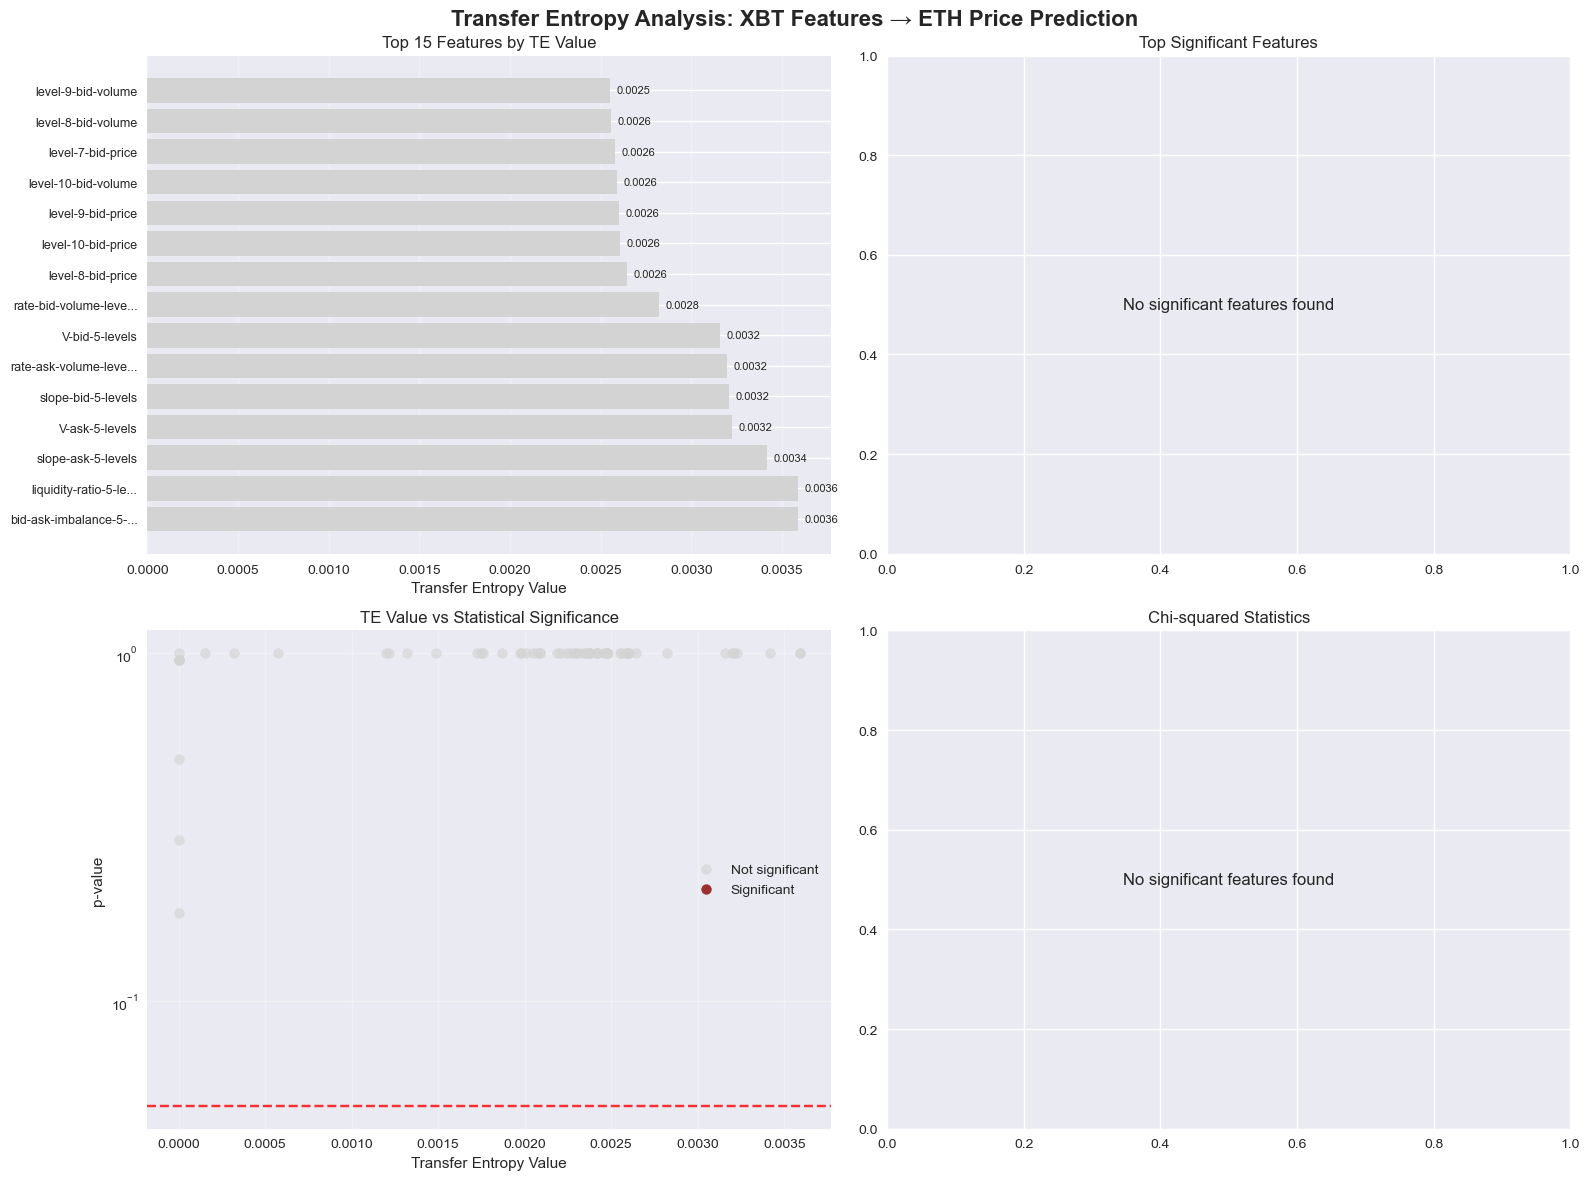


                    SUMMARY STATISTICS
Mean TE value: 0.001921
Std TE value: 0.001029
Max TE value: 0.003589
Min TE value: 0.000000
Median p-value: 1.000000
Features with p < 0.001: 0
Features with p < 0.01: 0
Features with p < 0.05: 0

⚠️  No statistically significant features found at α = 0.05 level
Consider:
- Increasing sample size
- Adjusting time shift parameters
- Using different binning strategies


In [ ]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Transfer Entropy Analysis: XBT Features → ETH Price Prediction', fontsize=16, fontweight='bold')

# 1. Bar plot of TE values
ax1 = axes[0, 0]
top_features = formatted_results.head(15)  # Show top 15 features
colors = ['darkred' if sig else 'lightgray' for sig in top_features['significant']]
bars = ax1.barh(range(len(top_features)), top_features['TE_value'], color=colors)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in top_features.index], fontsize=9)
ax1.set_xlabel('Transfer Entropy Value')
ax1.set_title('Top 15 Features by TE Value')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_features['TE_value'])):
    ax1.text(val + max(top_features['TE_value']) * 0.01, i, f'{val:.4f}', 
             va='center', fontsize=8)

# 2. Bar plot of top significant features only
ax2 = axes[0, 1]
significant_features = formatted_results[formatted_results['significant']].head(15)
if len(significant_features) > 0:
    bars2 = ax2.barh(range(len(significant_features)), significant_features['TE_value'], color='darkred', alpha=0.8)
    ax2.set_yticks(range(len(significant_features)))
    ax2.set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in significant_features.index], fontsize=9)
    ax2.set_xlabel('Transfer Entropy Value')
    ax2.set_title(f'Top {len(significant_features)} Significant Features by TE Value')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars2, significant_features['TE_value'])):
        ax2.text(val + max(significant_features['TE_value']) * 0.01, i, f'{val:.4f}', 
                 va='center', fontsize=8)
else:
    ax2.text(0.5, 0.5, 'No significant features found', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Top Significant Features')

# 3. Scatter plot: TE vs p-value
ax3 = axes[1, 0]
significant_mask = formatted_results['significant']
ax3.scatter(formatted_results.loc[~significant_mask, 'TE_value'], 
           formatted_results.loc[~significant_mask, 'p_value'], 
           alpha=0.6, color='lightgray', label='Not significant', s=50)
ax3.scatter(formatted_results.loc[significant_mask, 'TE_value'], 
           formatted_results.loc[significant_mask, 'p_value'], 
           alpha=0.8, color='darkred', label='Significant', s=50)
ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.8)
ax3.set_xlabel('Transfer Entropy Value')
ax3.set_ylabel('p-value')
ax3.set_title('TE Value vs Statistical Significance')
ax3.set_yscale('log')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Chi-squared statistics
ax4 = axes[1, 1]
sig_features = formatted_results[formatted_results['significant']]
if len(sig_features) > 0:
    ax4.bar(range(len(sig_features)), sig_features['chi2_statistic'], 
            color='darkred', alpha=0.7)
    ax4.set_xticks(range(len(sig_features)))
    ax4.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                        for name in sig_features.index], 
                       rotation=45, ha='right', fontsize=8)
    ax4.set_ylabel('χ² Statistic')
    ax4.set_title(f'Chi-squared Statistics (Significant Features: {len(sig_features)})')
    ax4.grid(axis='y', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No significant features found', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Chi-squared Statistics')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print(" " * 20 + "SUMMARY STATISTICS")
print("="*60)
print(f"Mean TE value: {formatted_results['TE_value'].mean():.6f}")
print(f"Std TE value: {formatted_results['TE_value'].std():.6f}")
print(f"Max TE value: {formatted_results['TE_value'].max():.6f}")
print(f"Min TE value: {formatted_results['TE_value'].min():.6f}")
print(f"Median p-value: {formatted_results['p_value'].median():.6f}")
print(f"Features with p < 0.001: {(formatted_results['p_value'] < 0.001).sum()}")
print(f"Features with p < 0.01: {(formatted_results['p_value'] < 0.01).sum()}")
print(f"Features with p < 0.05: {(formatted_results['p_value'] < 0.05).sum()}")

if formatted_results['significant'].any():
    print("\nMost significant features (by TE value):")
    sig_sorted = formatted_results[formatted_results['significant']].sort_values('TE_value', ascending=False)
    for i, (idx, row) in enumerate(sig_sorted.head(5).iterrows()):
        print(f"{i+1}. {idx}: TE={row['TE_value']:.6f}, p={row['p_value']:.6f}")
else:
    print("\n⚠️  No statistically significant features found at α = 0.05 level")
    print("Consider:")
    print("- Increasing sample size")
    print("- Adjusting time shift parameters")
    print("- Using different binning strategies")
    
print("="*60)